# Kex NIRS "pedal to the metal"

In [1]:
# TBD: create bash script
# To download kssl dataset
# pip install gdown install --upgrade --no-cache-dir gdown

# cd /root
# python
# import gdown
# Links: 
#   - VNIR LUCAS: "1OnwGgDqvjnDYEik14h_lSi83M4AwzYBt"
#   - VNIR KSSL: "17ZNSqsQi6PUeOLnUozq-C6Pj22dItm_Y"
# id = "1qh8isMQIzhArsj3RNWJe6g0lx_cs7iBG" # MIRS KSSL v1 or "1SzQZqpbJuK3iCqjJYabuEobbgPXm3cHT" for v2
# gdown.download(id=id)
# quit()
# tar -xvf kssl.tar.gz

# paperspace only
#!pip install gdown 
#!pip install --upgrade gdown

In [2]:
#!pip install spanda

In [3]:
%load_ext autoreload
%autoreload 2

In [118]:
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import pandas as pd
from collections import namedtuple
from functools import partial

# from fastcore.foundation import L
# from fastcore.basics import risinstance
# import fastcore as fc
import fastcore.all as fc

import numpy as np

# from fastai.vision.all import *
# from fastai.data.all import *
import torch
from torch import tensor, nn, optim
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torch.nn import init

import timm

from spanda.miniai.init import init_weights, GeneralRelu, BatchTransformCB
from spanda.miniai.activations import ActivationStats
from spanda.miniai.sgd import BatchSchedCB
from spanda.miniai.learner import (Learner, TrainCB, DeviceCB, Callback,
                                   ProgressCB, MetricsCB, SingleBatchCB)

from torcheval.metrics import (R2Score, BinaryF1Score, BinaryPrecision,
                               BinaryRecall, BinaryAccuracy)
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

## Configs

In [5]:
is_local = True
root_dir = Path('../../_data/') if is_local else Path('.')

## Utils

In [6]:
def meet_criteria(src_dir, analyte='725'):
    has_spectrum = len(fc.L(fname for fname in src_dir.ls() if fname.name != 'target.csv')) > 0
    y_in_range = (pd.read_csv(src_dir / 'target.csv', 
                              dtype={'analyte': str, 'value': float},
                              index_col='analyte').loc[analyte] > 0).value
    return has_spectrum and y_in_range

In [7]:
get_spectra = lambda o: fc.L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

In [8]:
def get_paths(src_dir, analytes=['725']):     
    path = Path(src_dir)
    
    # Only samples with spectra
    paths = [p for p in tqdm(path.ls()) if len(p.ls()) > 1]
    
    # Only strictly positive measurements
    paths = [p for p in tqdm(paths) if AnalytesTfm(analytes=analytes)(get_target(p)) > 0] 
    
    return fc.L(paths)

In [9]:
def get_x(src_dir, index='wavelength'):
    fnames = fc.L(fname for fname in src_dir.ls() if fname.name != 'target.csv')
    dfs = (pd.read_csv(fname, index_col=index) for fname in fnames)
    df = pd.concat(dfs, axis=1, ignore_index=False)
    return torch.tensor(df.values, dtype=torch.float).T

def get_y(src_dir, analytes=None):
    df = pd.read_csv(src_dir / 'target.csv', dtype={'analyte': str, 'value': float})
    if analytes: df = df[df.analyte.isin(analytes)]
    return torch.tensor(df['value'].values, dtype=torch.float)

# item transforms
class AvgTfm:
    def __init__(self, weighted=False):
        self.weighted = weighted
        
    def __call__(self, x): 
        if self.weighted:
            return self._weights(len(x))@x
        else:
            return torch.mean(x, dim=0, keepdim=True)
    
    def _weights(self, n):
        weights = torch.rand(n)
        return (weights/weights.sum()).unsqueeze(dim=0).to(device)
 
# batch transforms
def _snv(b):
    x, y, *metadata  = b
    mean, std = torch.mean(x, dim=2, keepdim=True), torch.std(x, dim=2, keepdim=True)
    return ((x - mean)/std), y, *metadata

def _log10(b):
    x, y = b
    return x, torch.log10(y)

class SpecDataset(Dataset):
    def __init__(self, src_dirs, get_x, get_y, 
                 threshold: None,
                 transform=None, target_transform=None, metadata=None):
        self.src_dirs = src_dirs
        self.transform = transform
        self.target_transform = target_transform
        self.get_x = get_x
        self.get_y = get_y
        self.threshold = threshold
        self.metadata = metadata
        
    def __len__(self):
        return len(self.src_dirs)

    def __getitem__(self, idx):
        x, y =  (getter(self.src_dirs[idx]) for getter in [self.get_x, self.get_y])
        if self.transform: x = self.transform(x)
        if self.target_transform: y = self.target_transform(y)
        if self.threshold: y = (y >= self.threshold).float()
        if self.metadata:
            metadata = [m[idx] for m in self.metadata]
            return x, y.squeeze(), *metadata
        else:
            return x, y.squeeze()
    
def get_dls(train_ds, valid_ds, bs, **kwargs):
    Dataloaders = namedtuple('Dataloader', ['train', 'valid'])
    return Dataloaders(
        DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
        DataLoader(valid_ds, batch_size=bs*2, **kwargs)) 

In [10]:
current_date = lambda: datetime.now().date().isoformat()

## Data loading

In [11]:
analytes = ['725'] # Kex

In [12]:
paths = Path(root_dir / 'kssl-vnir').ls(); paths
paths_kssl = fc.L([path for path in tqdm(paths) if meet_criteria(path)]); paths_kssl

100%|██████████| 21004/21004 [00:13<00:00, 1577.81it/s]


(#20949) [Path('../../_data/kssl-vnir/163161'),Path('../../_data/kssl-vnir/110493'),Path('../../_data/kssl-vnir/97322'),Path('../../_data/kssl-vnir/166413'),Path('../../_data/kssl-vnir/92650'),Path('../../_data/kssl-vnir/47957'),Path('../../_data/kssl-vnir/170576'),Path('../../_data/kssl-vnir/120206'),Path('../../_data/kssl-vnir/42419'),Path('../../_data/kssl-vnir/78584')...]

In [13]:
paths = Path(root_dir / 'lucas-vnir').ls(); paths
paths_lucas = fc.L([path for path in tqdm(paths) if meet_criteria(path)]); paths_lucas

100%|██████████| 21782/21782 [00:13<00:00, 1611.55it/s]


(#21779) [Path('../../_data/lucas-vnir/28261972'),Path('../../_data/lucas-vnir/43443418'),Path('../../_data/lucas-vnir/42221892'),Path('../../_data/lucas-vnir/36742852'),Path('../../_data/lucas-vnir/45963284'),Path('../../_data/lucas-vnir/39082546'),Path('../../_data/lucas-vnir/54202132'),Path('../../_data/lucas-vnir/46821620'),Path('../../_data/lucas-vnir/33522030'),Path('../../_data/lucas-vnir/37362192')...]

In [143]:
paths_all = paths_kssl + paths_lucas; paths_all
# paths_all = paths_all[:1000]

(#42728) [Path('../../_data/kssl-vnir/163161'),Path('../../_data/kssl-vnir/110493'),Path('../../_data/kssl-vnir/97322'),Path('../../_data/kssl-vnir/166413'),Path('../../_data/kssl-vnir/92650'),Path('../../_data/kssl-vnir/47957'),Path('../../_data/kssl-vnir/170576'),Path('../../_data/kssl-vnir/120206'),Path('../../_data/kssl-vnir/42419'),Path('../../_data/kssl-vnir/78584')...]

In [144]:
# metadata
src = fc.L([0 if ('kssl' in p.as_posix()) else 1 for p in paths_all])

In [145]:
# y bin threshold
threshold = 0.5

In [146]:
# Stratification array
y_bin = [0 if partial(get_y, analytes=['725'])(path) > threshold else 1 for path in tqdm(paths_all)]
strats = [str(a) + str(b) for (a, b) in zip(y_bin, src)]; strats[:10]

100%|██████████| 42728/42728 [00:27<00:00, 1539.75it/s]


['10', '10', '00', '10', '10', '10', '00', '00', '00', '10']

In [175]:
paths_train, paths_valid, src_train, src_valid = train_test_split(paths_all, src, test_size=0.2,
                                                                  stratify=strats,
                                                                  random_state=41)


train_ds, valid_ds = [SpecDataset(paths,
                                  get_x=get_x,
                                  get_y=partial(get_y, analytes=['725']),
                                  threshold=threshold,
                                  transform=AvgTfm(),
                                  metadata=[src]
                                  )
                      for (paths, src) in [(paths_train, src_train), (paths_valid, src_valid)]]

# n_features = train_ds[0][0].shape[-1]

dls = get_dls(train_ds, valid_ds, bs=64, num_workers=8)

In [176]:
next(iter(dls.train))[1]

tensor([0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
        0., 0., 0., 0., 0., 1., 1., 1., 0., 0.])

## GADF + resize tfm

In [177]:
class GADFTfm(): 
    """
    Transform batch of spectra S (B, 1, len(S)) into their Grammian Difference Matrix Field (GADF) of shape (B, 1, H, W)
    
    Notes:
    https://arxiv.org/pdf/1506.00327.pdf
    """
    def __init__(self, neg=True):
        self.neg = neg
        
    def rescale(self, x):
        m = torch.min(x, dim=-1, keepdim=True).values
        M = torch.max(x, dim=-1, keepdim=True).values
        return ((x - M) + (x - m)) / (M - m) if self.neg else (x - m) / (M - m)

    def __call__(self, 
                 b # Batch of spectra S: (B, 1, len(S))
                 ): 
        x, y, *metadata = b
        X, I = self.rescale(x), torch.ones_like(x)
        K = torch.sqrt(I - torch.square(X))
        x = (torch.matmul(torch.transpose(K, 1, 2), X) - 
             torch.matmul(torch.transpose(X, 1, 2), K)).unsqueeze_(1)
        return x, y, *metadata

In [178]:
class StatsTfm(): 
    """
    Set pre-trained statistics
    """
    def __init__(self, cfgs):
        self.mean = np.array(cfgs['mean']).mean()
        self.std = np.array(cfgs['std']).mean()

    def __call__(self, b): 
        x, y, *metadata = b
        means = torch.mean(x, (2, 3), keepdim=True)
        stds = torch.std(x, (2, 3), keepdim=True)
        x = (((x - means) / stds) * self.std) + self.mean
        return x, y, *metadata

In [179]:
def _resizeTfm(b, size=224):
    x, y, *metadata  = b
    return T.Resize(size)(x), y, *metadata

In [180]:
_resizeTfm(GADFTfm()(next(iter(dls.train))))[0].shape

torch.Size([64, 1, 224, 224])

In [181]:
x_ = StatsTfm(default_cfgs['resnet18'])(_resizeTfm(GADFTfm()(next(iter(dls.train)))))[0]
torch.std(x_,(2, 3))[0]

tensor([0.2260])

## Train & evaluate

### Models

In [182]:
# avail_pretrained_models = timm.list_models(pretrained=True)
# len(avail_pretrained_models), avail_pretrained_models

In [183]:
# ?timm.create_model

In [184]:
# https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055

model_name = 'resnet18'
model = timm.create_model(model_name, pretrained=True, in_chans=1, num_classes=1)
x     = torch.randn(16, 1, 224, 224)
model(x)

tensor([[ 0.9367],
        [ 0.0853],
        [ 0.6263],
        [ 0.2167],
        [ 0.2258],
        [ 0.5631],
        [ 0.5644],
        [-0.2030],
        [ 0.5147],
        [ 0.5446],
        [ 0.1394],
        [ 0.1226],
        [ 0.9518],
        [ 0.8369],
        [ 0.6685],
        [ 0.4999]], grad_fn=<AddmmBackward0>)

In [185]:
model.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=1, bias=True),
     nn.Flatten(start_dim=0))
    # nn.Sigmoid())

In [186]:
from timm.models.resnet import default_cfgs
default_cfgs[model_name]

{'url': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bilinear',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv1',
 'classifier': 'fc'}

### Train/eval

In [187]:
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): 
        learn.preds = learn.model(*learn.batch[:self.n_inp])
        
    def get_loss(self, learn): 
        # import pdb; pdb.set_trace()
        learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:self.n_inp+1])
        
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

In [188]:
# Fitting
epochs = 3
lr = 5e-3

# act_gr = partial(nn.LeakyReLU, negative_slope=0.01)
# iw = partial(init_weights, leaky=0.01)
# iw = init_weights

# model = get_model(act=act_gr)
# model.apply(init_weights)

# metrics = MetricsCB(r2=R2Score())
# f1 = F1Score(task="multiclass", num_classes=3)
# BinaryAccuracy(threshold=0.7)


# metrics = MetricsCB(f1=BinaryF1Score())
metrics = MetricsCB(accuracy=BinaryAccuracy(threshold=0.5))
              #       presision=BinaryPrecision(),
              #       recall=BinaryRecall())

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]

# astats = ActivationStats(fc.risinstance(nn.Conv1d))
# astats = ActivationStats(fc.risinstance(nn.BatchNorm1d))

snv = BatchTransformCB(_snv)
gadf = BatchTransformCB(GADFTfm())
resize = BatchTransformCB(_resizeTfm)
stats = BatchTransformCB(StatsTfm(default_cfgs[model_name]))
# logY = BatchTransformCB(_log10)

# when regression apply logY
# cbs = [DeviceCB(), snv, logY, gadf, resize, TrainCB(), 

cbs = [DeviceCB(), snv, gadf, resize, stats, TrainCB(), 
       metrics, ProgressCB(plot=False)]

# learn = Learner(model, dls, nn.MSELoss(), lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn = Learner(model, dls, nn.BCELoss(), lr=1e-3, cbs=cbs+xtra, opt_func=optim.AdamW)
# learn = Learner(model, dls, nn.BCELoss(), lr=1e-3, cbs=cbs, opt_func=optim.AdamW)

In [189]:
# learn.lr_find()

In [190]:
learn.fit(epochs)

accuracy,loss,epoch,train
0.591,1.074,0,train
0.624,0.659,0,eval
0.625,0.660,1,train
0.624,0.665,1,eval
0.625,0.664,2,train
0.625,0.665,2,eval


### Train Convnet

In [158]:
# Fitting
epochs = 20
lr = 1e-3

# act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
# iw = partial(init_weights, leaky=0.1)

act_gr = partial(nn.LeakyReLU, negative_slope=0.01)
iw = partial(init_weights, leaky=0.01)
iw = init_weights

model = get_model(act=act_gr)
model.apply(init_weights)
metrics = MetricsCB(r2=R2Score())

snvX = BatchTransformCB(_snv)
logY = BatchTransformCB(_log10)

cbs = [DeviceCB(), snvX, logY, TrainCB(), metrics]

learn = Learner(model, dls, nn.MSELoss(), lr=2e-2, cbs=cbs, opt_func=optim.AdamW)

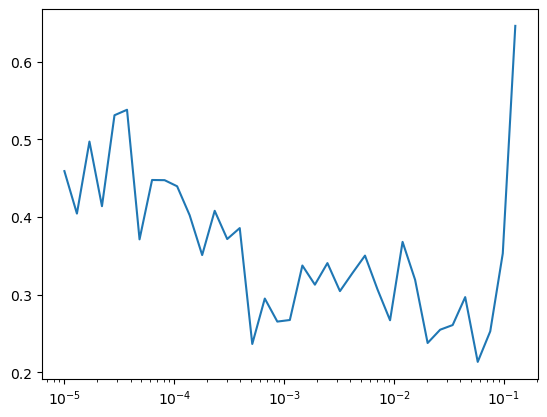

In [151]:
learn.lr_find()

In [223]:
# Fitting
epochs = 20
lr = 5e-3

act_gr = partial(nn.LeakyReLU, negative_slope=0.01)
iw = partial(init_weights, leaky=0.01)
iw = init_weights


model = get_model(act=act_gr)
model.apply(init_weights)

metrics = MetricsCB(r2=R2Score())

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]

# astats = ActivationStats(fc.risinstance(nn.Conv1d))
astats = ActivationStats(fc.risinstance(nn.BatchNorm1d))

snvX = BatchTransformCB(_snv)
logY = BatchTransformCB(_log10)

cbs = [DeviceCB(), snvX, logY, TrainCB(), 
       metrics, ProgressCB(plot=False), astats]

learn = Learner(model, dls, nn.MSELoss(), lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)

In [224]:
learn.fit(epochs)

r2,loss,epoch,train
-0.088,0.259,0,train
0.326,0.166,0,eval
0.199,0.191,1,train
0.351,0.159,1,eval
0.317,0.162,2,train
0.365,0.156,2,eval
0.336,0.158,3,train
0.368,0.155,3,eval
0.335,0.158,4,train
0.372,0.154,4,eval


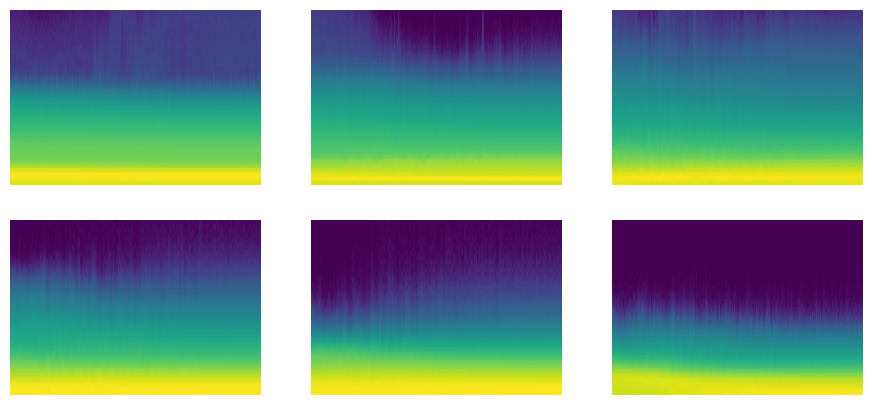

In [225]:
astats.color_dim(aspect='auto')

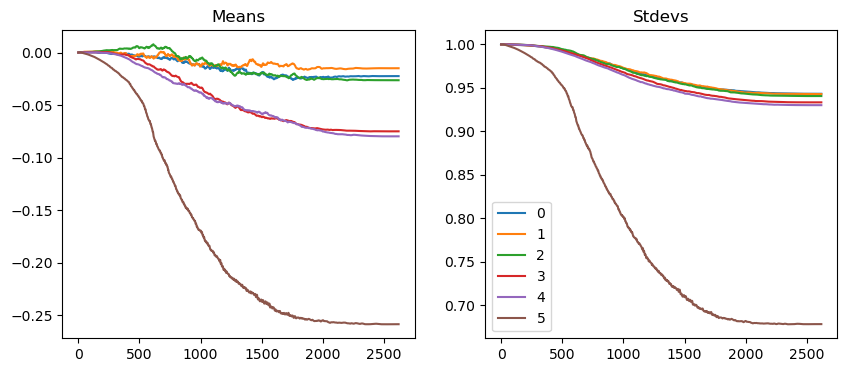

In [226]:
astats.plot_stats()

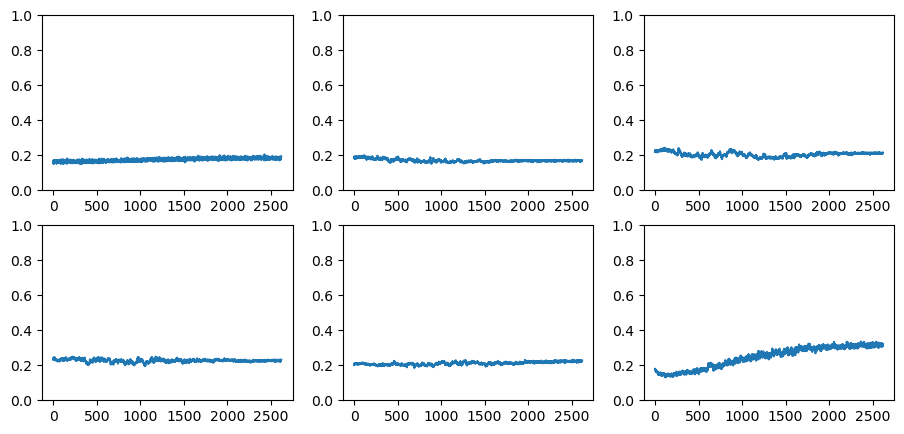

In [227]:
astats.dead_chart()